In [2]:
# enable reload the module
%load_ext autoreload
%autoreload 2

In [144]:
# Import the necessary modules
import argparse
import datetime
import glob
import os
import re
import time
from pathlib import Path

import numpy as np
import torch
from tensorboardX import SummaryWriter

from eval_utils import eval_utils
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets import build_dataloader
from mtr.models import model as model_utils
from mtr.utils import common_utils
from mtr.datasets.waymo.waymo_dataset import WaymoDataset
from torch.utils.data import DataLoader

from visualization.vis_utils import plot_map, plot_signal, plot_traj_with_time


In [4]:
cfg_file = '/hdd/Git_Repo/MTR/tools/cfgs/waymo/mtr_eval.yaml'

cfg_from_yaml_file(cfg_file, cfg)
cfg.TAG = Path(cfg_file).stem
cfg.EXP_GROUP_PATH = '/'.join(cfg_file.split('/')[1:-1])  # remove 'cfgs' and 'xxxx.yaml'

np.random.seed(1024)

# Set the output directory
output_dir = cfg.ROOT_DIR / 'output' / 'val_interactive'
output_dir.mkdir(parents=True, exist_ok=True)

eval_output_dir = output_dir / 'eval'
eval_output_dir.mkdir(parents=True, exist_ok=True)

log_file = eval_output_dir / ('log_eval_%s.txt' % datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
logger = common_utils.create_logger(log_file, rank=cfg.LOCAL_RANK)


In [49]:
# Build dataset
test_set, test_loader, sampler = build_dataloader(
    dataset_cfg=cfg.DATA_CONFIG,
    batch_size=1,
    dist=False, workers=1, logger=logger, training=False
)

2023-05-15 22:19:52,590   INFO  Start to load infos from /home/zixu/Data/Dataset/MTR_dataset/processed_scenarios_val_interactive_infos.pkl
2023-05-15 22:19:52,602   INFO  Total scenes before filters: 1441
2023-05-15 22:19:52,622   INFO  Total scenes after filter_info_by_object_type: 1441
2023-05-15 22:19:52,622   INFO  Total scenes after filters: 1441


In [42]:
# load model
model = model_utils.MotionTransformer(config=cfg.MODEL)
ckpt_path = '/hdd/Git_Repo/MTR/model/checkpoint_epoch_30.pth'
it, epoch = model.load_params_from_file(filename=ckpt_path, logger=logger, to_cpu=False)
model = model.cuda()

2023-05-15 22:15:25,765   INFO  ==> Loading parameters from checkpoint /hdd/Git_Repo/MTR/model/checkpoint_epoch_30.pth to GPU
2023-05-15 22:15:26,180   INFO  ==> Checkpoint trained from version: none
2023-05-15 22:15:26,180   INFO  The number of disk ckpt keys: 842
2023-05-15 22:15:26,234   INFO  Missing keys: []
2023-05-15 22:15:26,235   INFO  The number of missing keys: 0
2023-05-15 22:15:26,235   INFO  The number of unexpected keys: 0
2023-05-15 22:15:26,236   INFO  ==> Done (total keys 842)


In [52]:
model.eval()
for i, batch_dict in enumerate(test_loader):
    with torch.no_grad():
        batch_pred_dicts = model(batch_dict)
        final_pred_dicts = test_set.generate_prediction_dicts(batch_pred_dicts)
    break

836558b3c1e4fc13
dict_keys(['track_infos', 'dynamic_map_infos', 'map_infos', 'scenario_id', 'timestamps_seconds', 'current_time_index', 'sdc_track_index', 'objects_of_interest', 'tracks_to_predict'])
dict_keys(['object_id', 'object_type', 'trajs'])


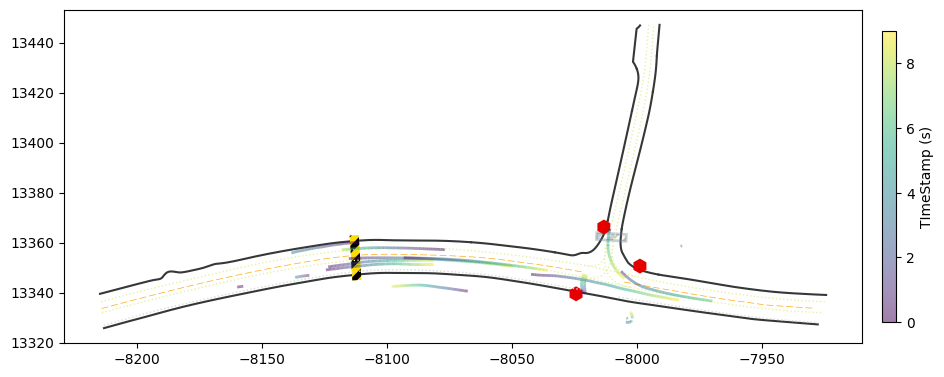

In [145]:
scene_id, info = test_set.load_info(0)
print(scene_id)
print(info.keys())
fig, ax = plot_map(info['map_infos'])

t = 0
dynamic_map_infos = info['dynamic_map_infos']
plot_signal(dynamic_map_infos, t, ax)

track_infos = info['track_infos']
print(track_infos.keys())

plot_traj_with_time(track_infos['object_type'], track_infos['trajs'], info['timestamps_seconds'], ax=ax, fig=fig)
